# GeoPandas Gridding Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook for trying out GeoPandas for gridding species observations.

### Import Python Packages

In [65]:
import os

import matplotlib.pyplot as plt

os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gp

import shapely

### Load sample species observation data
As an example a dataset from the Dutch 'Nationale Databank Flora en Fauna' (ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [66]:
# the NDFF datafile to process
obs_filename = "../../../local/data/ndff/broedvogels_2016.csv"

# the columns to drop right away
always_drop_cols_from_source = None

### Use a Pandas DataFrame for some pre-processing
Do some initial cleaning of the data first. Also fix the geometry data so it fits GeoPandas expectations.

In [67]:
# load the data into a regular pandas dataframe
obs_df = pd.read_csv(obs_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    obs_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
obs_df['wkt_excl_crs'] = obs_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
obs_df.drop(columns=['wkt'], inplace=True)
obs_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

obs_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON((247282 584478,247280.535533906 584474..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON((65405.294923655 436165.134083641,6540..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((188642.918478918 344195.927912087,188..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((169116.484375 446596.0625,169113.5554..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON((127692 427328,127689.071067812 427320..."


### Lift the data into a GeoPandas GeoDataFrame
Create a GeoPandas GeoDataFrame from the regular (non spatial aware) DataFrame. After that use GeoPandas functionality to transform the data from the Dutch coordinate reference system to WGS84.

In [68]:
# note that we used the pandas dataframe
obs_gs = gp.GeoSeries.from_wkt(obs_df['wkt'])
obs_gdf = gp.GeoDataFrame(obs_df, geometry=obs_gs, crs='EPSG:28992')

# transform the dataset to the more common WGS84 (unprojected) CRS
obs_gdf.to_crs(crs="EPSG:4326", inplace=True)
obs_gdf.drop(columns=['wkt'], inplace=True)

obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON ((6.76944 53.23891, 6.76942 53.23888, ..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON ((4.08519 51.90677, 4.08514 51.90670, ..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((5.86735 51.08631, 5.86731 51.08625, ..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((5.59280 52.00755, 5.59276 52.00749, ..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON ((4.99101 51.83388, 4.99097 51.83382, ..."


### Data selection

In [69]:
# spatially select observations within an area of interest
aoi_obs_gdf = obs_gdf.cx[4.0:4.5, 51.0:51.5]
aoi_obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
45,Nachtegaal,Luscinia megarhynchos,2016,levend exemplaar,1,71,"POLYGON ((4.24698 51.49430, 4.24696 51.49427, ..."
153,Rietzanger,Acrocephalus schoenobaenus,2016,territorium,1,283,"POLYGON ((4.20916 51.36639, 4.20912 51.36633, ..."
272,Kleine karekiet,Acrocephalus scirpaceus,2016,territorium,1,283,"POLYGON ((4.21405 51.36453, 4.21401 51.36446, ..."
324,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON ((4.40060 51.38335, 4.40056 51.38329, ..."
653,Ekster,Pica pica,2016,territorium,1,283,"POLYGON ((4.06072 51.31206, 4.06068 51.31199, ..."


<Axes: >

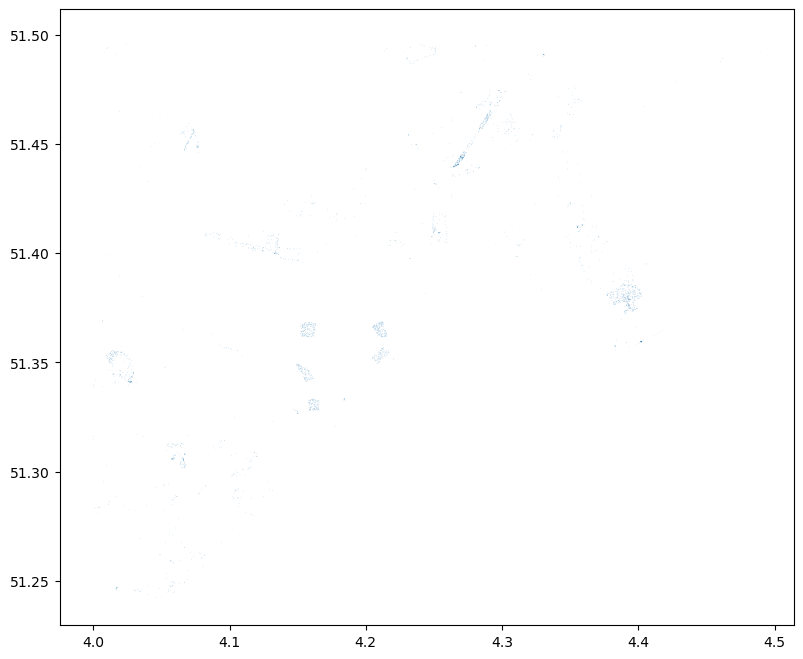

In [94]:
aoi_obs_gdf.plot(figsize=(12, 8))

### Create a GeoDataFrame with a grid
Construct a grid that covers the extent of the area of interest. This will later be used to aggregate the data into.


In [71]:
# total area for the grid
xmin, ymin, xmax, ymax= aoi_obs_gdf.total_bounds

# how many cells across and down
n_cells = 30
cell_size = (xmax - xmin) / n_cells

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

grid_gdf = gp.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:4326")

In [73]:
grid_gdf.head(3)

,geometry
0,"POLYGON ((3.98345 51.24239, 3.98345 51.25872, ..."
1,"POLYGON ((3.98345 51.25872, 3.98345 51.27504, ..."
2,"POLYGON ((3.98345 51.27504, 3.98345 51.29136, ..."


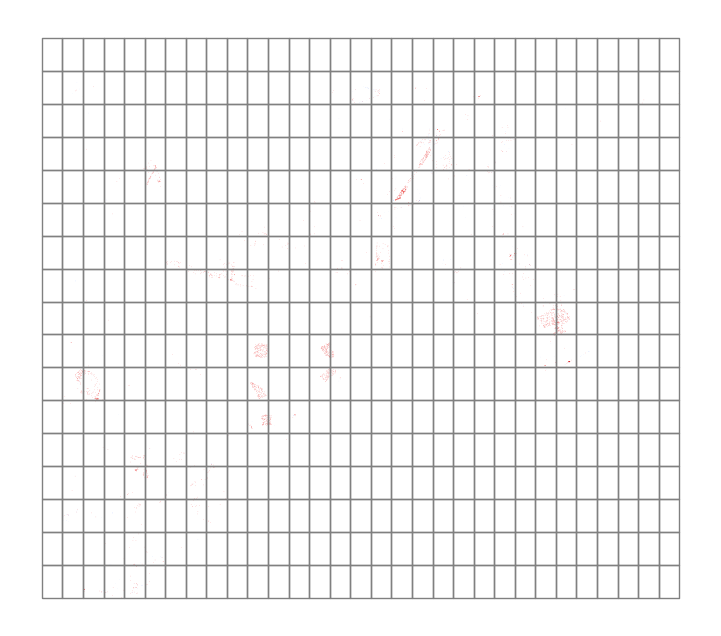

In [93]:
# plot the grid over the observations data
ax = aoi_obs_gdf.plot(markersize=0.5, figsize=(12, 8), column='straal', cmap='jet')
# plt.autoscale(False)
grid_gdf.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off");

### Merge the observations with the grid
Merge the observations with the grid using a spatial join. Then use a simple count to aggregate the data.

In [77]:
merged_aoi_gdf = gp.sjoin(aoi_obs_gdf, grid_gdf, how='left', predicate='within')

In [78]:
# make a count column
merged_aoi_gdf['n_obs'] = 1

# dissolve by count
dissolve = merged_aoi_gdf.dissolve(by='index_right', aggfunc='count')

# put the values into the grid
grid_gdf.loc[dissolve.index, 'n_obs'] = dissolve['n_obs'].values

/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Axes: >

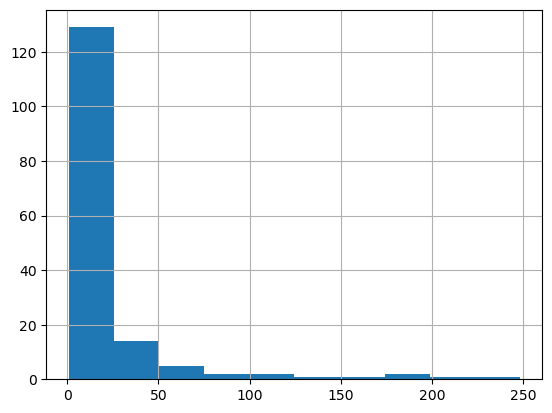

In [79]:
grid_gdf['n_obs'].hist()

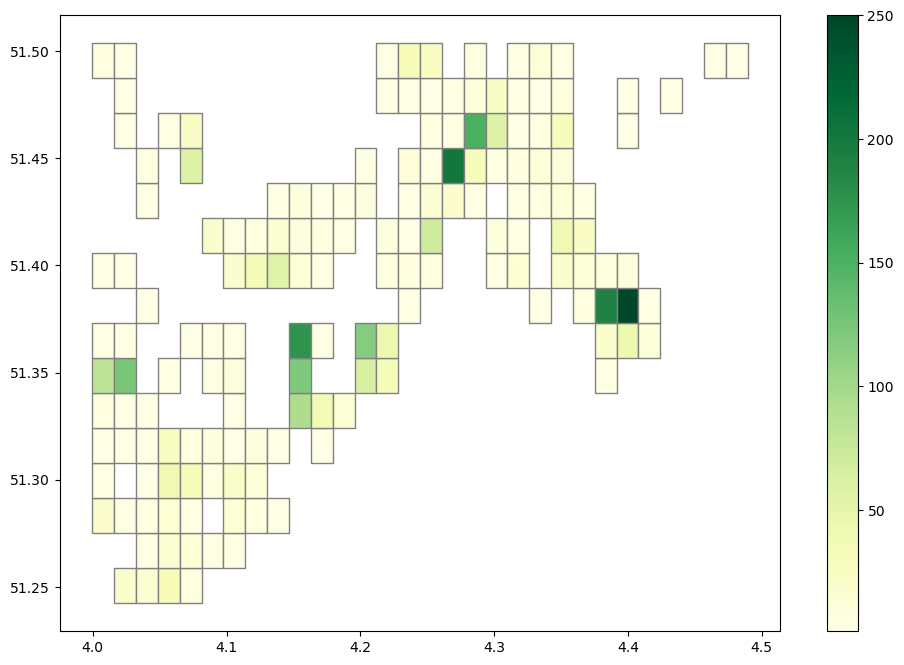

In [95]:
# plot the grid and the number of observations in each grid cell
grid_gdf.plot(
    column='n_obs',
    figsize=(12, 8),
    cmap='YlGn',
    vmax=250, # range max
    edgecolor='grey',
    legend=True
);